In [265]:
from QuoteDataset import QuotesDataset
import pandas as pd

In [266]:
path_to_data = "Data/CleanedData/"
train_df = QuotesDataset(path_to_data + "train_quotes.csv").data
val_df = QuotesDataset(path_to_data + "val_quotes.csv").data
test_df = QuotesDataset(path_to_data + "test_quotes.csv").data

In [267]:
unique_categories = QuotesDataset(path_to_data + "train_quotes.csv").data

In [268]:
def categories_seperated(dataframe):
    dataframe['categories'] = dataframe['categories'].apply(lambda x: x.split(';'))
    return dataframe

In [269]:
def count_categories(dataframe):
    categories = {}
    for index, row in dataframe.iterrows():
        for category in row['categories']:
            if category in categories:
                categories[category] += 1
            else:
                categories[category] = 1
    return categories

In [270]:
train_df = categories_seperated(train_df)
val_df = categories_seperated(val_df)
test_df = categories_seperated(test_df)


In [271]:
def group_by_categories(dataframe):
    dataframe = dataframe.explode('categories')
    grouped = dataframe.groupby('categories')['text'].apply(list)
    return grouped

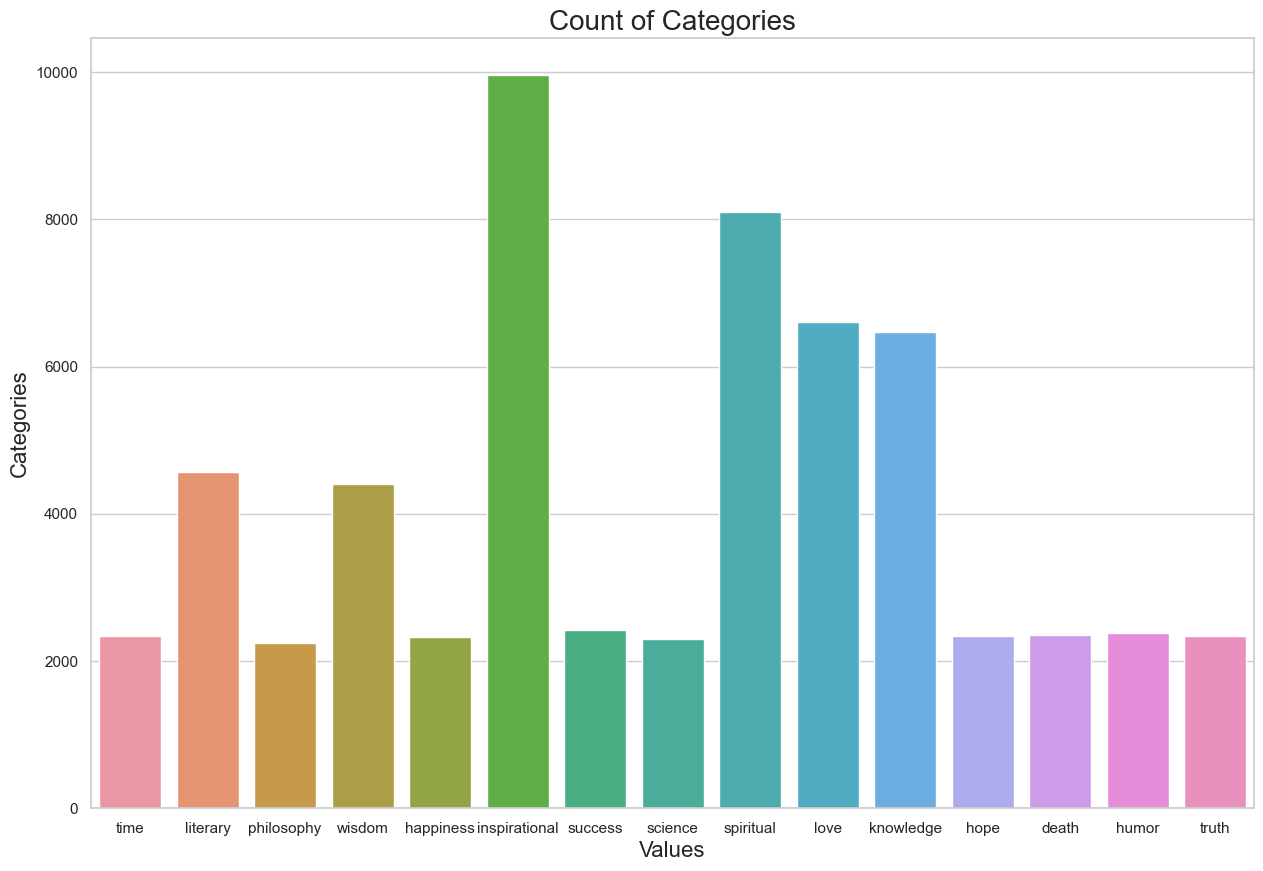

In [272]:
import seaborn as sns
train_counts = count_categories(train_df)

categories = list(train_counts.keys())
values = list(train_counts.values())

sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.barplot(x=categories, y=values)
plt.title('Count of Categories', fontsize=20)
plt.xlabel('Values', fontsize=16)
plt.ylabel('Categories', fontsize=16)
plt.show()

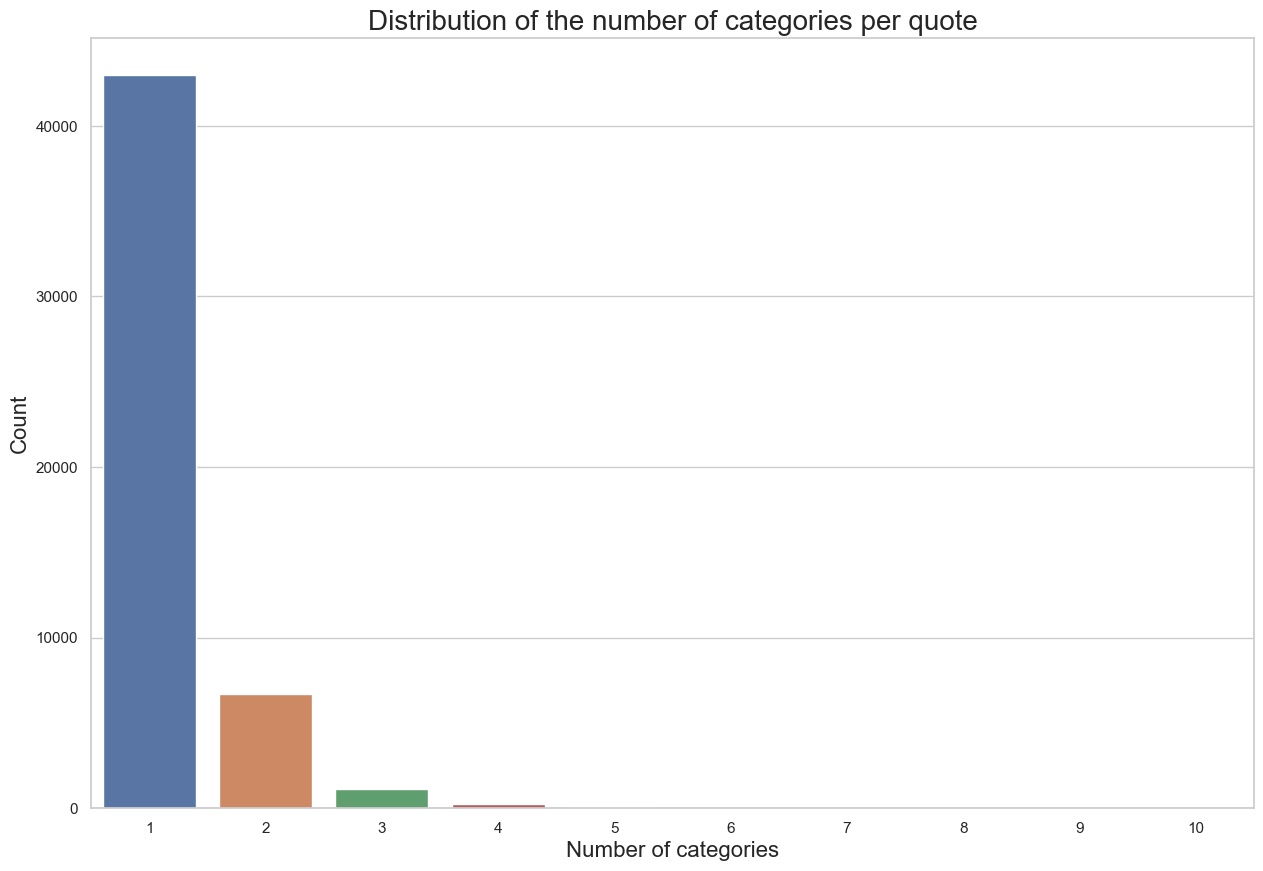

In [273]:
train_df['num_categories'] = train_df['categories'].apply(lambda x: len(x))
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.countplot(x='num_categories', data=train_df)
plt.title('Distribution of the number of categories per quote', fontsize=20)
plt.xlabel('Number of categories', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()


/Users/vinhpham/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


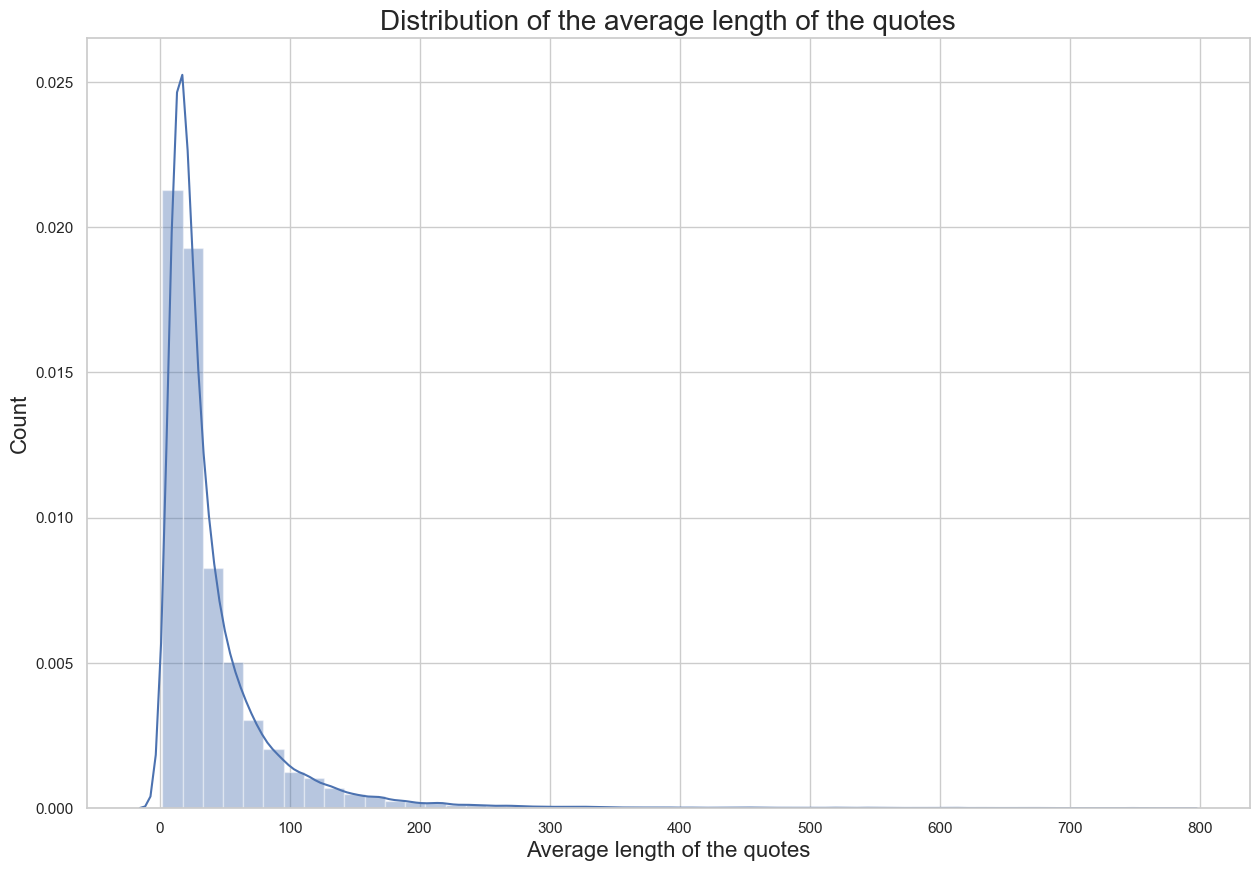

In [274]:
train_df['length'] = train_df['text'].apply(lambda x: len(x.split()))
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.distplot(train_df['length'])
plt.title('Distribution of the average length of the quotes', fontsize=20)
plt.xlabel('Average length of the quotes', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

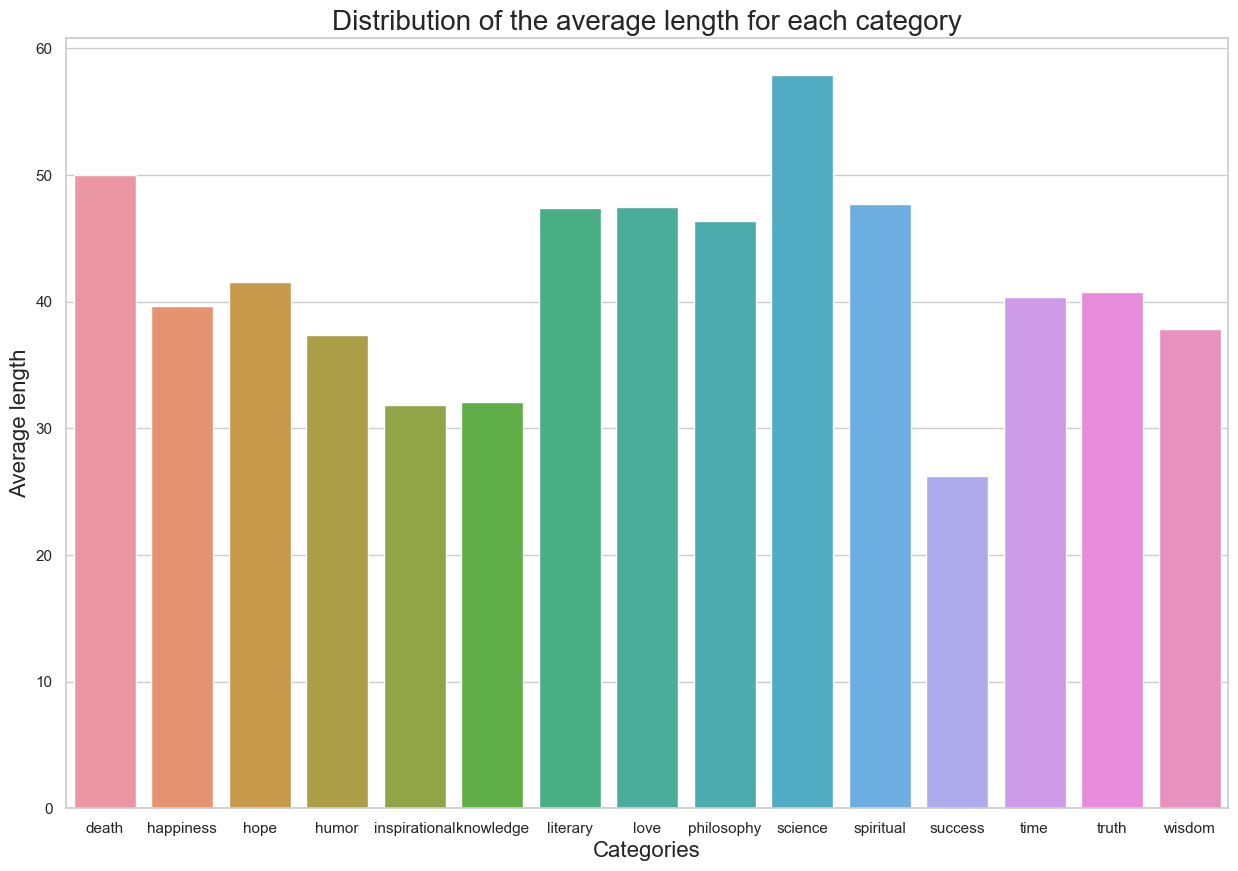

In [275]:
# Let's see the distribution of the average length for each category
grouped = group_by_categories(train_df)
categories = list(grouped.keys())
values = list(grouped.values)
lengths = []
for value in values:
    lengths.append(sum([len(x.split()) for x in value]) / len(value))

sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.barplot(x=categories, y=lengths)
plt.title('Distribution of the average length for each category', fontsize=20)
plt.xlabel('Categories', fontsize=16)
plt.ylabel('Average length', fontsize=16)
plt.show()


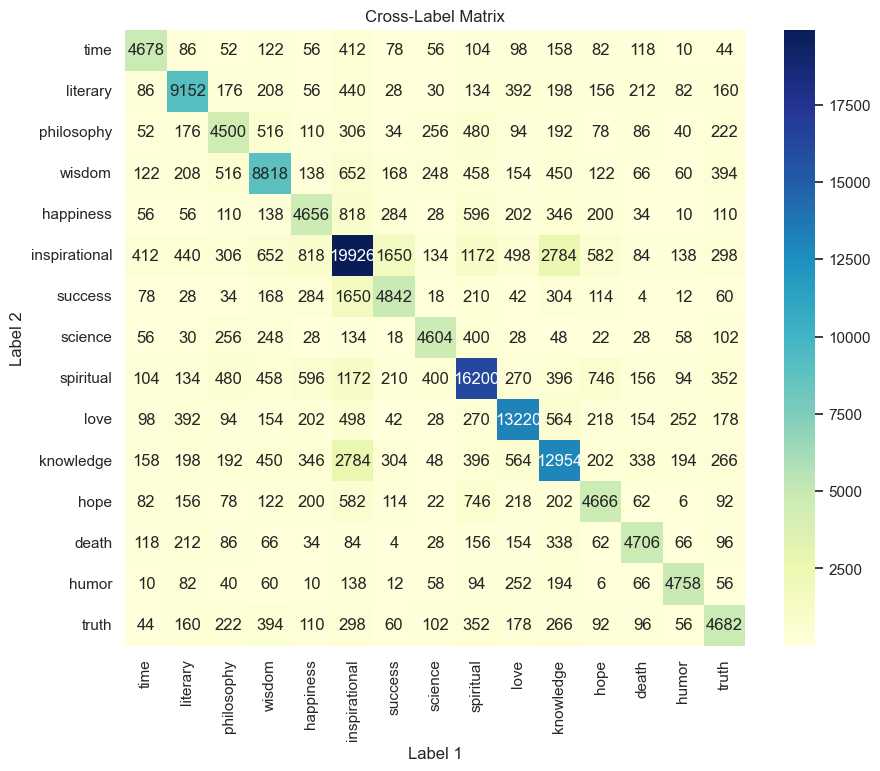

In [276]:
from collections import defaultdict
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

cross_label_dict = defaultdict(lambda: defaultdict(int))

for _, row in train_df.iterrows():
    for pair in itertools.product(row['categories'], repeat=2):
        pair = tuple(sorted(pair))
        cross_label_dict[pair[0]][pair[1]] += 1
        cross_label_dict[pair[1]][pair[0]] += 1

all_labels = list(cross_label_dict.keys())
cross_label_df = pd.DataFrame(0, index=all_labels, columns=all_labels)

for label1 in cross_label_dict:
    for label2 in cross_label_dict:
        cross_label_df.loc[label1, label2] = cross_label_dict[label1][label2]

cross_label_df = cross_label_df.fillna(0).astype(int)

plt.figure(figsize=(10, 8))
sns.heatmap(cross_label_df, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Cross-Label Matrix')
plt.xlabel('Label 1')
plt.ylabel('Label 2')
plt.show()

In [277]:
import heapq

co_occur_heap = []
heapq.heapify(co_occur_heap)
top_k = 15
for label1, label2 in itertools.combinations(all_labels, 2):
    heapq.heappush(co_occur_heap, (cross_label_df.loc[label1, label2], label1, label2))

    if len(co_occur_heap) > top_k:
        heapq.heappop(co_occur_heap)

top_co_occur = heapq.nlargest(top_k, co_occur_heap)

for count, label1, label2 in top_co_occur:
    print(f'{label1} and {label2} co-occur {count} times')

inspirational and knowledge co-occur 2784 times
inspirational and success co-occur 1650 times
inspirational and spiritual co-occur 1172 times
happiness and inspirational co-occur 818 times
spiritual and hope co-occur 746 times
wisdom and inspirational co-occur 652 times
happiness and spiritual co-occur 596 times
inspirational and hope co-occur 582 times
love and knowledge co-occur 564 times
philosophy and wisdom co-occur 516 times
inspirational and love co-occur 498 times
philosophy and spiritual co-occur 480 times
wisdom and spiritual co-occur 458 times
wisdom and knowledge co-occur 450 times
literary and inspirational co-occur 440 times


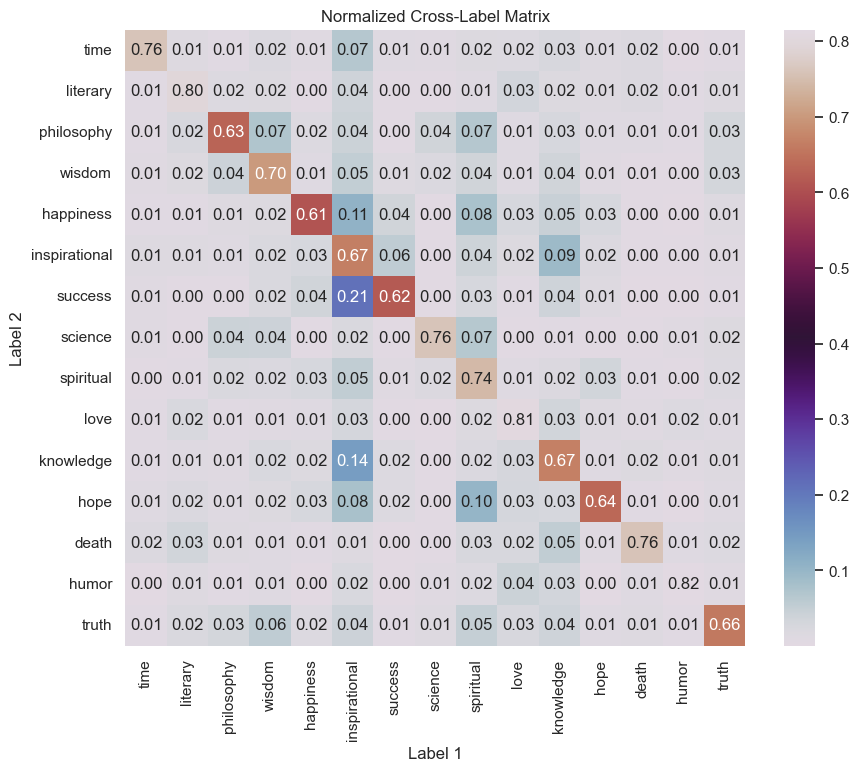

In [278]:
# Normalizing the co-occurrence matrix across rows

normalized_cross_label_df = cross_label_df.div(cross_label_df.sum(axis=1), axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(normalized_cross_label_df, annot=True, cmap="twilight", fmt='.2f')
plt.title('Normalized Cross-Label Matrix')
plt.xlabel('Label 1')
plt.ylabel('Label 2')
plt.show()

In [296]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
nltk.download('stopwords')

def get_top_k_words_category(quotes_list, k):
    words = []
    for quote in quotes_list:
        quote = word_tokenize(quote.lower())
        words.extend(quote)

    counter = Counter(words)

    # Remove non-alphabetic tokens, stopwords, and single-character tokens
    for word in list(counter):
        if word in string.punctuation or word in stopwords.words('english') or len(word) == 1:
            counter.pop(word, None)
            
    for word in stopwords.words('english'):
        counter.pop(word, None)
        
    return counter.most_common(k)

top_k = 1

# Generate a dataframe with k columns for each category
top_k_words_dataframe = pd.DataFrame(columns=[f'{rank+1}' for rank in range(top_k)], index=all_labels)


for category in all_labels:
    word_list = grouped[category]
    top_k_words = get_top_k_words_category(word_list, top_k)
    for rank, (word, count) in enumerate(top_k_words):
        top_k_words_dataframe.loc[category, f'{rank+1}'] = word

top_k_words_dataframe
    
 
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vinhpham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1
time                time
literary            like
philosophy           one
wisdom         knowledge
happiness      happiness
inspirational       life
success          success
science          science
spiritual            god
love                love
knowledge           life
hope                hope
death              death
humor                 ''
truth              truth

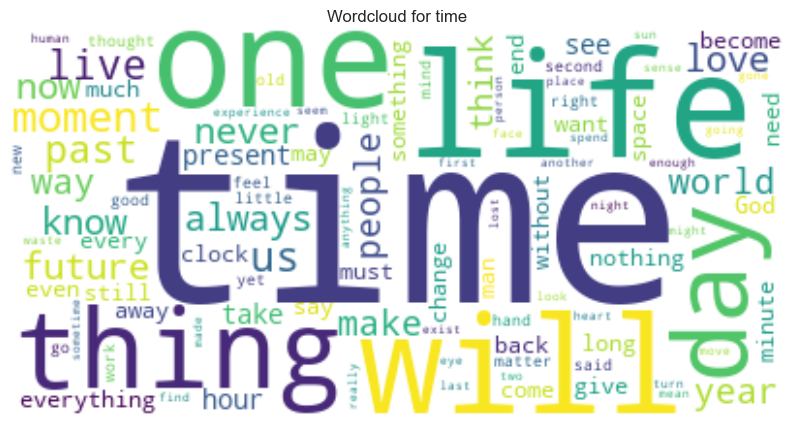

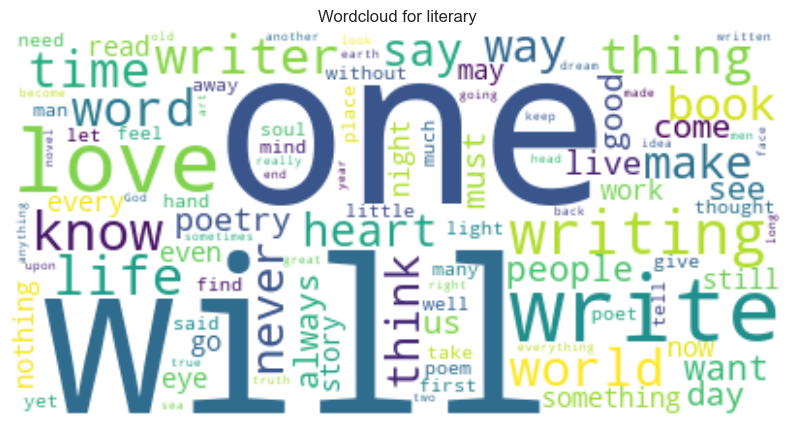

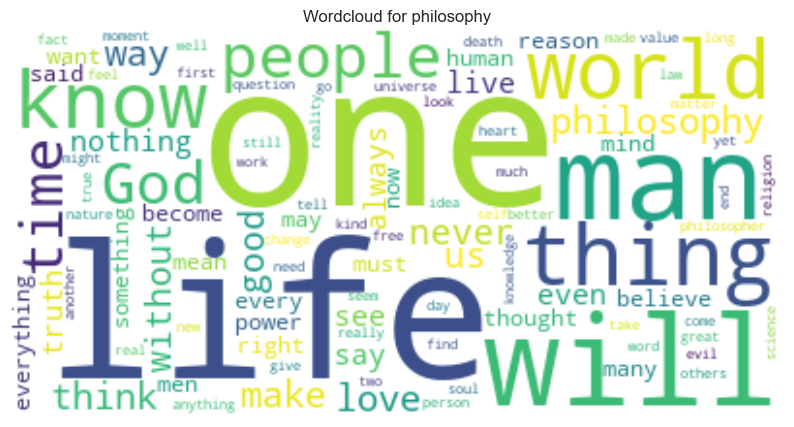

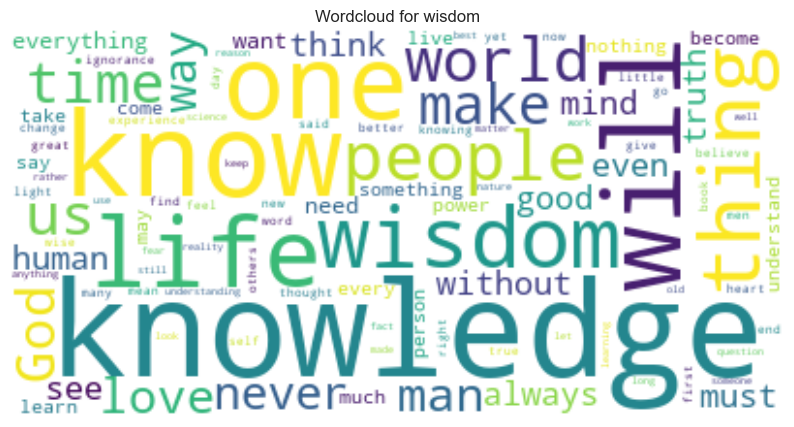

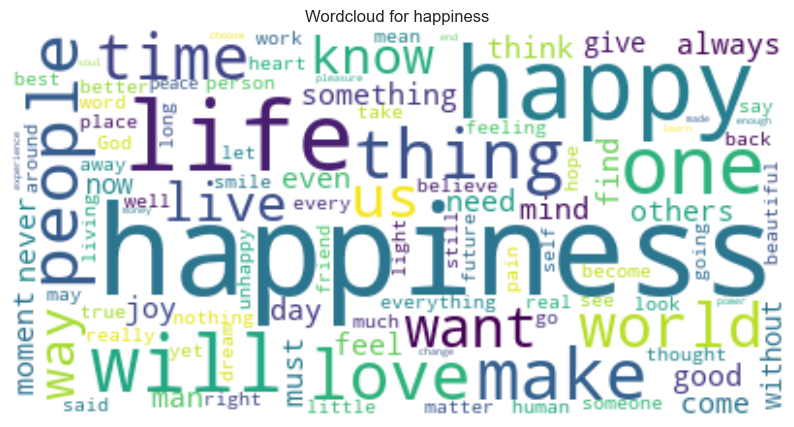

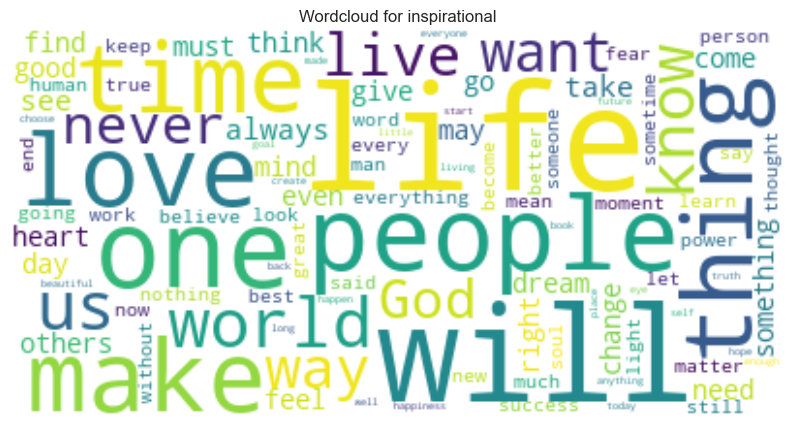

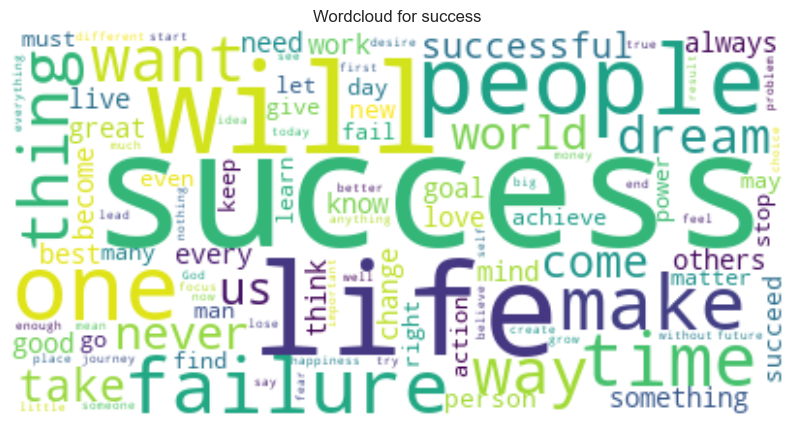

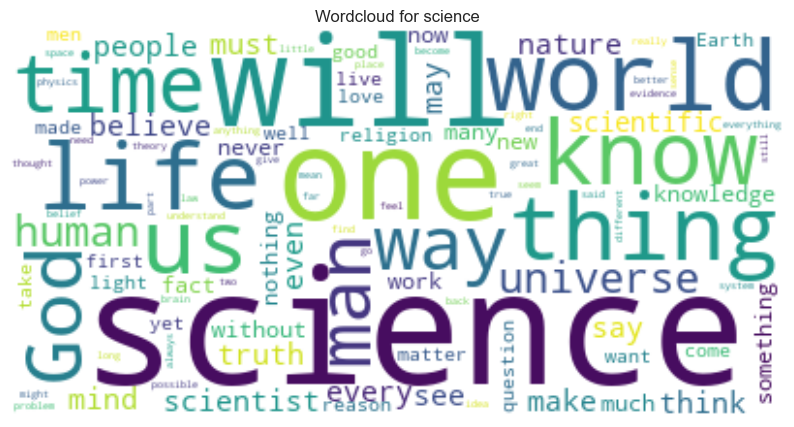

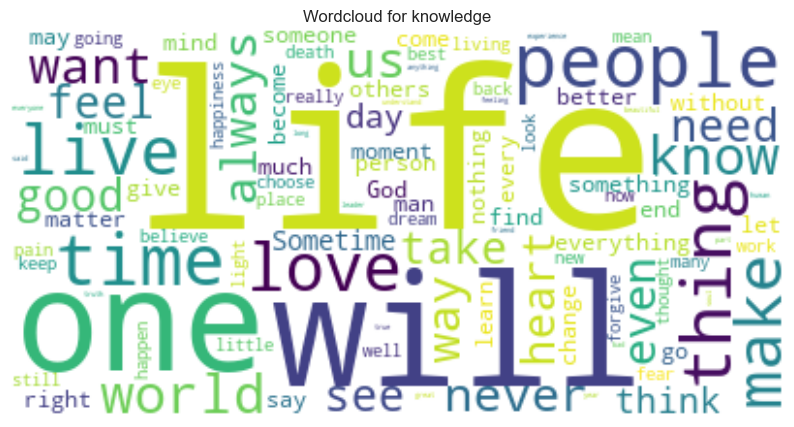

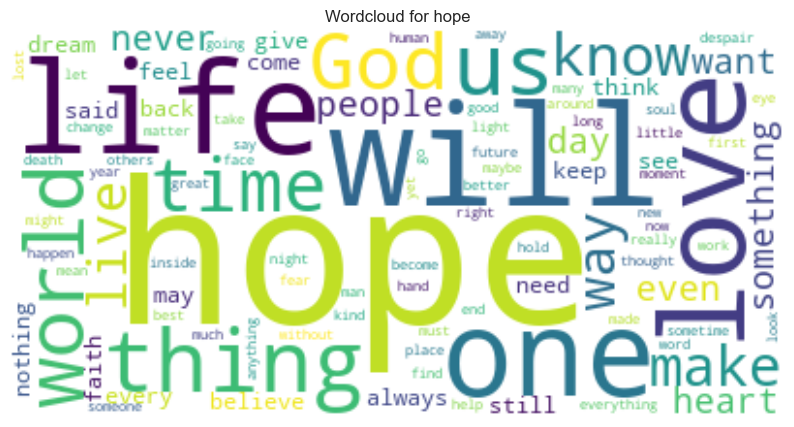

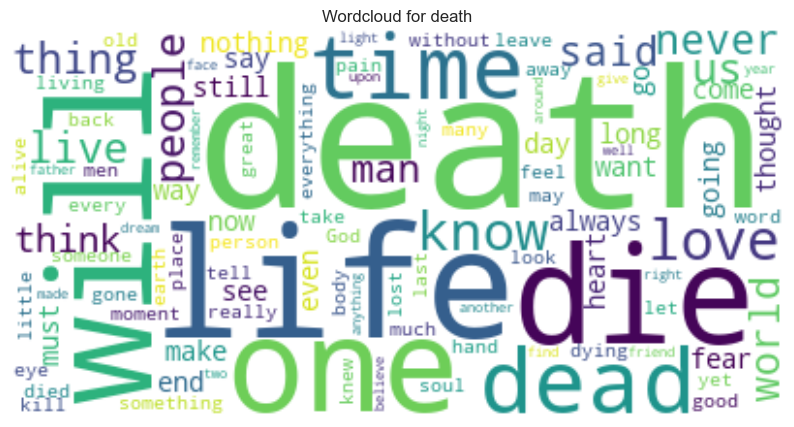

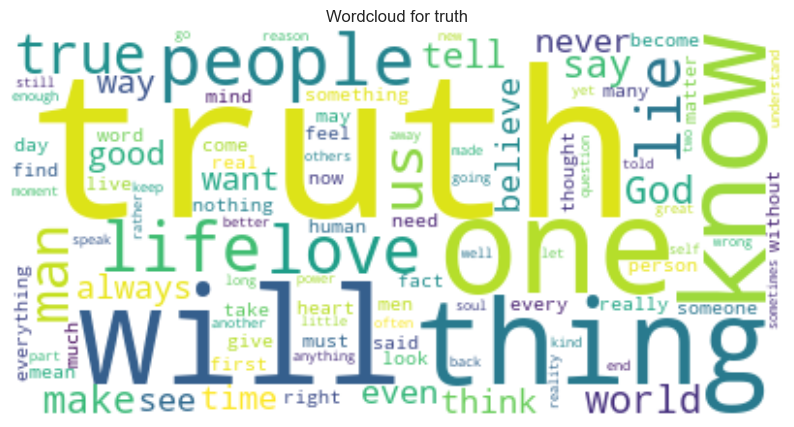

In [280]:
# Build a word cloud for each category
from wordcloud import WordCloud

def generate_wordcloud(category):
    word_list = grouped[category]
    wordcloud = WordCloud(max_words=100, background_color="white").generate(' '.join(word_list))
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Wordcloud for {category}')
    plt.show()

for category in all_labels:
    generate_wordcloud(category)

    

In [297]:
# Count the number of unique words in each category
unique_words = {}
train_data = set()
for category in all_labels:
    word_list = grouped[category]
    unique_words[category] = len(set(word_list))
    print(f'There are {unique_words[category]} unique words in the {category} category')
    train_data.update(word_list)

print(f'There are {len(train_data)} unique words in the training data')





There are 2339 unique words in the time category
There are 4570 unique words in the literary category
There are 2250 unique words in the philosophy category
There are 4406 unique words in the wisdom category
There are 2328 unique words in the happiness category
There are 9960 unique words in the inspirational category
There are 2421 unique words in the success category
There are 2302 unique words in the science category
There are 8097 unique words in the spiritual category
There are 6610 unique words in the love category
There are 6471 unique words in the knowledge category
There are 2333 unique words in the hope category
There are 2353 unique words in the death category
There are 2379 unique words in the humor category
There are 2341 unique words in the truth category
There are 51135 unique words in the training data
